In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'whole_gen_9_after_words_attention'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
sample_data = sample_data[sample_data['class'] != 'MANUAL']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 654333,  (dropped rows: 9263859)


In [7]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS', 'NUMBERS', 'PLAIN', 'VERBATIM']
5


### Utils stuff

In [8]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [9]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [10]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [11]:
#onehot_sos = torch.zeros(1, 1, len(words_after_index))
#onehot_sos[0, 0, words_after_index[SOS_TOKEN]] = 1
#onehot_sos.size()
#del(onehot_sos)

sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

### More balanced sample

In [12]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_length = 0
def balanced_data_randomize(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_accessed_counter = 0

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_accessed_counter/balanced_data_length > 0.2:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [14]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
ELECTRONIC     4964
LETTERS       20000
NUMBERS       20000
PLAIN         20000
VERBATIM      11741
Name: class, dtype: int64

In [15]:
 balanced_data_sample_row()

sentence_id                                                70756
token_id                                                       8
class                                                    LETTERS
before                                                      przy
after                                                    p r z y
class_org                                                LETTERS
a_word_ind                                  [24, 35, 105, 86, 0]
sentence       jana bytnara " rudego " w mielcuszkola podstaw...
Name: 61468, dtype: object

### Samples

In [16]:
def get_random_sample():
    sample_row = balanced_data_sample_row()
    sentence_id = sample_row['class']
    
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

NUMBERS : 1855 -> eighteen fifty five <EOS> [40, 38, 14, 0]
in <SAMPLE> kazakhs displaced from their nomadic territory appeared in verniy .
torch.Size([1, 5, 104])


In [17]:
%%timeit
get_random_sample()

155 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [18]:
use_cuda = True

In [42]:
len('3123-5703-6077-8121-9900')

24

In [57]:
tmp = sample_data[sample_data['before'].str.len()>50]
len(tmp)
tmp.sample(2)
tmp[~tmp['before'].str.contains('/')].sample(2)

499

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
471808,540725,2,ELECTRONIC,http://www.anglicantheologicalreview.org/read/...,h t t p colon slash slash w w w dot a n g l i ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","abstract : <SAMPLE> , david ."
518135,592477,4,ELECTRONIC,http://www.centerforpubliceducation.org/Main-M...,h t t p colon slash slash w w w dot c e n t e ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","retrieved 2 july 2009 , from <SAMPLE> , e . b ..."


,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
426722,491251,1,ELECTRONIC,StoneDeadline.comDeadline.comDeadline.comDeadl...,s t o n e d e a d l i n e dot c o m d e a d l ...,ELECTRONIC,"[17, 30, 25, 29, 28, 26, 28, 22, 26, 42, 31, 2...",deadline . comdeadline . comvarietydeadline . ...
231443,265794,3,ELECTRONIC,2000Myspace.comTempleofschlock.blogpsot.comBil...,t w o o o o m y s p a c e dot c o m t e m p l ...,ELECTRONIC,"[30, 52, 25, 25, 25, 25, 32, 86, 17, 24, 22, 2...","7th edn , <SAMPLE> vol 89 # 8 ( 26 february 19..."


In [58]:
MAX_ATTENTION_LENGTH = 50

### Encoder

In [60]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)
                
        output = torch.cat((output_words[0], output_chars[0]), 0)

        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, hidden_states_cat

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): LSTM(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(104, 128, batch_first=True, bidirectional=True)
)

In [76]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(encoder_output, encoder_outputs), tmp = test_encoder_single_sample()
tmp
encoder_output.size()
encoder_outputs.size()
torch.eq(encoder_output, encoder_outputs[len(tmp)]).data.all()

A. M.


'A. M.'

torch.Size([384])

torch.Size([50, 384])

True

### Decoder

In [77]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        #self.rnn = nn.GRU(input_size, hidden_size, n_layers,
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
        
        self.lin_out = nn.Linear(hidden_size, input_size)
        #self.softmax = nn.LogSoftmax()
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.embedding(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #IPython.core.debugger.Pdb().set_trace()
        #attn_weights = F.softmax(self.attn(torch.cat((char[0], hidden[0]), 1)))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.lin_out(output[0]))
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]

DecoderRNN (
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 1351)
  (embedding): Embedding(1351, 384)
  (attn): Linear (768 -> 50)
  (attn_combine): Linear (768 -> 384)
  (dropout): Dropout (p = 0.1)
)

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 50])]

In [78]:
torch.bmm(torch.FloatTensor([1,0.1,0.1]).view(1,1,-1), torch.arange(0, 12).view(1,3,-1))


(0 ,.,.) = 
  1.2000  2.4000  3.6000  4.8000
[torch.FloatTensor of size 1x1x4]

In [79]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after_common[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 50])]

Variable containing:
 242
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

s's


# Training etc

### Accuracy

In [80]:
def test_model_single_sample(model=None, return_more=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
        
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        decoder_intput = torch.LongTensor([word_index])
        #decoder_input = torch.zeros(1, 1, len(words_after_index))
        #decoder_input[0, 0, word_index] = 1
        #decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

("fifths s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's",
 "fifths s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's",
 'i e p m a',
 ('IEPMA',
  [31, 28, 24, 32, 22, 0],
  'LETTERS',
  'the association was reconstituted in penticton , british columbia in 1992 as the <SAMPLE> , with dudley gordon as its first president .'))

In [81]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

0              => fifths s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's || [104, 0] 
                  isbn <SAMPLE> - 471 - 08364 - x . koszinowski , j . ( 1980 ) .
www.hopenow.tv => fifths s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's s's || [52, 52, 52, 74, 45, 25, 24, 28, 29, 25, 52, 74, 30, 54, 0] 
                  hopenow . tv is available on cable in the roanoke lynchburg market , and via free live streaming from their website : <SAMPLE> .


In [82]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 2.36 s, sys: 52 ms, total: 2.42 s
Wall time: 2.42 s


0.0

### Training

In [83]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_intput = torch.LongTensor([word_index])
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [84]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [85]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/whole_gen_9_after_words_attention


In [86]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   5.606   |   6.88: & -> <EOS> (✗: [55, 0]) (forcing)
Saved model to data/models/whole_gen_9_after_words_attention/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
    18  36% (  0m 52s)   5.503   |   6.51: & -> <EOS> (✗: [55, 0]) (forcing)
    27  54% (  0m 52s)   5.270   |   6.83: 28 December 2013 -> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> (✗: [11, 6, 80, 12, 65, 6, 49, 0]) (forcing)
    36  72% (  0m 52s)   5.202   |   1.47: WPCR- ->  (✗: [52, 24, 21, 35, 0]) 
    45  90% (  0m 52s)   4.904   |   3.25: & ->  (✗: [55, 0]) 


In [87]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (  0m 10s)   3.042   |   1.65: - ->  (✗: [57, 0]) 


In [88]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 21s)   2.793   |   4.83: programme -> nineteen (✗: [139, 0]) 
  3000  22% (  0m 40s)   2.474   |   4.09: 10,000 -> the twenty twenty (✗: [44, 8, 0]) (forcing)
  4000  33% (   1m 1s)   2.318   |   2.25: mr -> to (✗: [117, 0]) 
  5000  44% (  1m 22s)   2.278   |   3.80: 11 -> p (✗: [48, 0]) 
  6000  56% (  1m 44s)   2.098   |   6.25: November 4, 1996 -> h i t a a m (✗: [69, 77, 7, 23, 20, 0]) (forcing)
  7000  67% (   2m 5s)   2.010   |   0.02: & -> and (✓) (forcing)
  8000  78% (  2m 27s)   1.973   |   1.46: 2009 -> nineteen thousand <EOS> (✗: [5, 8, 15, 0]) (forcing)
  9000  89% (  2m 50s)   1.969   |   2.94: programmes -> center (✗: [184, 0]) (forcing)
 10000 100% (  3m 12s)   1.955   |   0.01: & -> and (✓) 


In [89]:
train_iterations(n_iters=90000, print_every=10000)

 20000  11% (  3m 51s)   1.164   |   0.00: & -> and (✓) (forcing)
 30000  22% (   8m 2s)   0.874   |   0.78: 60 -> sixty (✓) 
 40000  33% ( 11m 56s)   0.689   |   0.00: - -> to (✓) (forcing)
 50000  44% ( 15m 26s)   0.609   |   0.03: ISBN -> i s b n (✓) (forcing)
Saved model to data/models/whole_gen_9_after_words_attention/50000_(EncoderRNN/DecoderRNN)
Accuracy: 70.12% (    7012/   10000)
 60000  56% (  20m 9s)   0.490   |   0.41: INI -> i n i (✓) 
 70000  67% (  24m 4s)   0.465   |   1.80: 287.1 -> two point point seven seventy <EOS> (✗: [5, 10, 27, 18, 46, 9, 0]) (forcing)
 80000  78% (  28m 4s)   0.552   |   0.01: UCI -> u c i (✓) 
 90000  89% ( 31m 53s)   0.484   |   0.44: 1566 -> sixteen sixty six (✗: [51, 39, 20, 0]) 
100000 100% ( 35m 44s)   0.441   |   1.97: MySQL -> m s s l (✗: [32, 86, 17, 111, 42, 0]) 
Saved model to data/models/whole_gen_9_after_words_attention/100000_(EncoderRNN/DecoderRNN)
Accuracy: 78.00% (    7800/   10000)


In [142]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

111889   5% (  3m 30s)   0.411   |   0.94: Gsp.ro -> g p p dot o (✗: [53, 17, 24, 74, 35, 25, 0]) 
121889  10% (  7m 15s)   0.416   |   0.01: # -> number (✓) 
131889  15% ( 10m 59s)   0.423   |   0.00: S. H. -> s h (✓) (forcing)
141889  20% ( 14m 44s)   0.463   |   0.10: CSSI -> c s s i (✓) (forcing)
Saved model to data/models/whole_gen_9_after_words_attention/150000_(EncoderRNN/DecoderRNN)
Accuracy: 82.65% (    8265/   10000)
151889  25% ( 19m 40s)   0.366   |   2.91: http://www.humboldt.edu/celt/tips/micro-lectures_just-in-time_teaching_for_critical_topics_and_skills/Center -> h t slash colon colon w w w w w w dot s dot o s o s s o s o o s o s s o s e s s e s e o s e s s e s e s s e s e e s e e s e s e e s e e e e s e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e (✗: [45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74, 45

KeyboardInterrupt: 

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0005)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

**We were using wrong sample data before this. From this point on we have removed 'manual'-class**

In [ ]:
sample_data[sample_data['before'] == 'σ']

In [ ]:
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=10000)

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

### Show attention

input:   Jeuneafrique.com
output:  ['j', 'e', 'u', 'u', 'u', 'e', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'dot', 'c', 'o']
target:    j e u n e a f r i q u e dot c o m


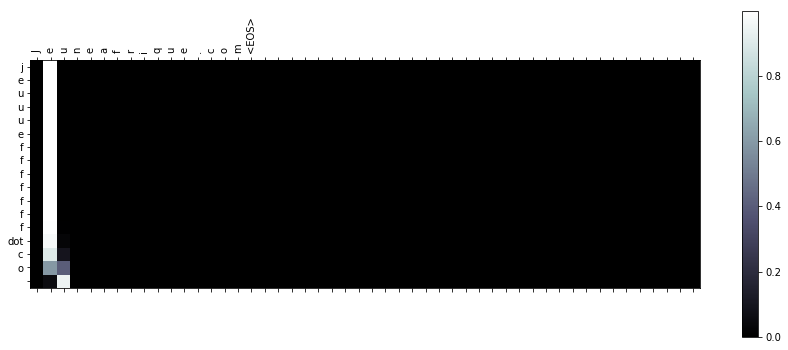

In [179]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input:  ', sample[0])
    print('output: ', decoded_output)
    print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)
    
debug_eval_sample_show_attention()


In [ ]:
tmp = [r/sum(r) for r in attns]
plt.matshow(tmp)

In [ ]:
np.argmax(attns, 1)
[attns[k,v] for k, v in enumerate(np.argmax(attns, 1))]